<a href="https://colab.research.google.com/github/mnansary/pyF2O/blob/master/colab_gen_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab specific task
*   mount google drive
*   change working directory to git repo
*   TPU check



In [0]:
!pip3 install tensorflow==1.13.1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My\ Drive/PROJECTS/MED/pySKIND

## TPU Check

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

tf.__version__

# ConvNet Model Training

### Data

In [5]:
import sys
sys.path.append('.')

from coreLib.utils import readh5
import numpy as np 
class PARAMS:
    DS_DIR  = '/content/gdrive/My Drive/PROJECTS/MED/Train/' # @param
    BATCH_SIZE      = 128  # @param
    NUM_EPOCHS      = 100  # @param
    IMAGE_DIM       = 64  # @param
    NB_CHANNELS     = 3    # @param
    X_TRAIN_IDEN    = 'X_train.h5'  # @param
    Y_TRAIN_IDEN    = 'Y_train.h5'  # @param
    X_EVAL_IDEN     = 'X_eval.h5'  # @param
    Y_EVAL_IDEN     = 'Y_eval.h5'  # @param
    MODEL_DIR       = '/content/gdrive/My Drive/PROJECTS/MED/MODEL_DIR/' # @param
    MODEL_NAME      = 'convNet' # @param

X_train=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.X_TRAIN_IDEN))
Y_train=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.Y_TRAIN_IDEN))
X_eval=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.X_EVAL_IDEN))
Y_eval=readh5(os.path.join(PARAMS.DS_DIR,PARAMS.Y_EVAL_IDEN))

X_train=X_train.astype('float32')/255.0
X_eval=X_eval.astype('float32')/255.0

print(X_train.shape)
print(Y_train.shape)
print(X_eval.shape)
print(Y_eval.shape)


(24192, 64, 64, 3)
(24192, 2)
(1152, 64, 64, 3)
(1152, 2)


### Compile Model

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from coreLib.models import conv_net
'''
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)
with strategy.scope():
'''
model=conv_net(img_dim=PARAMS.IMAGE_DIM,nb_channels=PARAMS.NB_CHANNELS)
model.summary()
model.compile(optimizer=Adam(), 
              loss=categorical_crossentropy,
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv

### Train

In [7]:
#from tensorflow.keras.callbacks import ModelCheckpoint   
#checkpointer = ModelCheckpoint(filepath=os.path.join(PARAMS.MODEL_DIR,'{}.h5'.format(PARAMS.MODEL_NAME)), 
                               #verbose=1, 
                               #save_best_only=True)

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

model = tf.contrib.tpu.keras_to_tpu_model(model,
                                          strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

history=model.fit(X_train,Y_train,
                  validation_data=(X_eval,Y_eval),
                  epochs=PARAMS.NUM_EPOCHS,
                  batch_size=PARAMS.BATCH_SIZE, 
                  verbose=1)#callbacks=[checkpointer],


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.70.65.82:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14757374119799272116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17656851471750636384)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13035032970506400596)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

### Plot Training Histoty

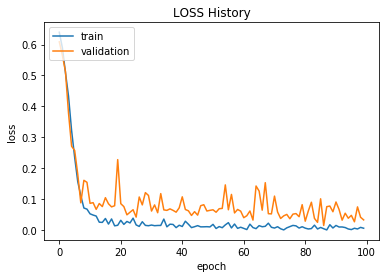

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(PARAMS.MODEL_DIR,'{}_history.png'.format(PARAMS.MODEL_NAME)))

### F1 Score

In [9]:
from sklearn import metrics
X_TEST_H5_DIR='/content/gdrive/My Drive/PROJECTS/MED/Test/X_test.h5' # @param
Y_TEST_H5_DIR='/content/gdrive/My Drive/PROJECTS/MED/Test/Y_test.h5' # @param
x_test=readh5(X_TEST_H5_DIR)
y_test=readh5(Y_TEST_H5_DIR)
x_test=x_test.astype('float32')/255.0
y_true =[np.argmax(y) for y in y_test]
total_data=x_test.shape[0]
y_pred=[]
for i in range(0,total_data,PARAMS.BATCH_SIZE):
  y_batch=[]
  x_batch=x_test[i:i+PARAMS.BATCH_SIZE]
  y_batch=model.predict(x_batch)
  for y_data in y_batch:
    y_pred.append(np.argmax(y_data))
f1_accuracy =100* metrics.f1_score(y_true,y_pred, average = 'micro')
print('F1 SCORE:{} % '.format(f1_accuracy))

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 64, 64, 3), dtype=tf.float32, name='conv2d_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.9815871715545654 secs
F1 SCORE:98.4375 % 


### Save Model Weights

In [10]:
model.save_weights(os.path.join(PARAMS.MODEL_DIR,'{}_final.h5'.format(PARAMS.MODEL_NAME)))

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False
